# Generate Training Points

## Background

**Training data** is the most important part of any supervised machine learning workflow. The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)).  A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034).

There are many platforms to use for gathering land cover training labels, the best one to use depends on your application. GIS platforms are great for collecting training data as they are highly flexible and mature platforms; [Geo-Wiki](https://www.geo-wiki.org/) and [Collect Earth Online](https://collect.earth/home) are two open-source websites that may also be useful depending on the reference data strategy employed. Alternatively, there are many pre-existing training datasets on the web that may be useful, e.g. [Radiant Earth](https://www.radiant.earth/) manages a growing number of reference datasets for use by anyone. With locations of land cover labels available, we can extract features at these locations from satellite imagery as input for machine learning.  

## Description

As timely training data is not always available, in this notebook we demonstrate how to generate a set of randomly distributed training points for a selected district in Rwanda from an existing classification map.

The workflow includes the following steps:

1. Preview the district boundaries of Rwanda on a basemap
2. Select a district as area of analysis
3. Merging classes on the classification map to keep only those you want
4. Generate randomly distributed training points and export for future use

***

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

Note: The approximate running time for the default setting is about 2 minutes.

### Load packages


In [13]:
%matplotlib inline
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch
from random_sampling import random_sampling # adapted from function by Chad Burton: https://gist.github.com/cbur24/04760d645aa123a3b1817b07786e7d9f
from datacube.utils.cog import write_cog

## Analysis parameters

* `input_polygons_path`: The path to the shapefile containing polygons of Rwanda administrative boundaries. Here we use [administrative level 3 boundaries file](https://geoportal.icpac.net/layers/geonode%3Arwa_adm3). 
* `input_map_path`: The classification map used to extract the training points. Here we use the [Rwanda Land Cover 2015 Scheme II map](http://geoportal.rcmrd.org/layers/servir%3Arwanda_landcover_2015_scheme_ii).
* `name_attribute`: This is the name of column in your shapefile attribute table that identifies the name of each polygon at an administrative level.
>**Note**: If you change your file to a different shapefile, remember to update this variable to identify your area of interest.
* `output_crs`: Output spatial reference system.

In [14]:
input_polygons_path = 'Data/rwa_adm3.shp'
input_map_path='Data/rwanda_landcover_2015_scheme_ii.tif'
name_attribute = 'NAME_3'
output_crs='epsg:32735' # WGS84/UTM Zone 35S

## Load and display input data
Let's load the administration polygons:

In [15]:
polygons=gpd.read_file(input_polygons_path)
polygons.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,CCN_3,CCA_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
0,189,RWA,Rwanda,1,Amajyaruguru,1,Burera,1,Bungwe,4401,4401,Sector,Sector,None,None,"POLYGON ((29.98542 -1.45859, 29.98555 -1.45892..."
1,189,RWA,Rwanda,1,Amajyaruguru,1,Burera,2,Butaro,4402,4402,Sector,Sector,None,None,"POLYGON ((29.85182 -1.34369, 29.85192 -1.34424..."
2,189,RWA,Rwanda,1,Amajyaruguru,1,Burera,3,Cyanika,4403,4403,Sector,Sector,None,None,"POLYGON ((29.73102 -1.34058, 29.73149 -1.34087..."
3,189,RWA,Rwanda,1,Amajyaruguru,1,Burera,4,Cyeru,4404,4404,Sector,Sector,None,None,"POLYGON ((29.81518 -1.47519, 29.81554 -1.47526..."
4,189,RWA,Rwanda,1,Amajyaruguru,1,Burera,5,Gahunga,4405,4405,Sector,Sector,None,None,"POLYGON ((29.68848 -1.37768, 29.69047 -1.38383..."


Let's load the classification map and display it:

In [16]:
classification_map=xr.open_dataset(input_map_path,engine="rasterio").astype(np.uint8)
classification_map=classification_map.to_array().squeeze()

According to its metadata of the classification map, it conatains 15 classes including Nodata represented by its pixel values: Nodata (0), Dense Forest (1), Moderate Forest (2), Sparse Forest (3), Woodland (4), Closed Grassland (5), Open Grassland (6), Closed Shrubland (7), Open Shrubland (8), Perennial Cropland (9), Annual Cropland (10), Wetland (11), Water Body (12), Urban Settlement (13) and Other Land (14). Here we define a dictionary of class name corresponding to pixel values for dispaly:

>**Note**: If you change the classification map, you will need to understand what class each pixel value represents.

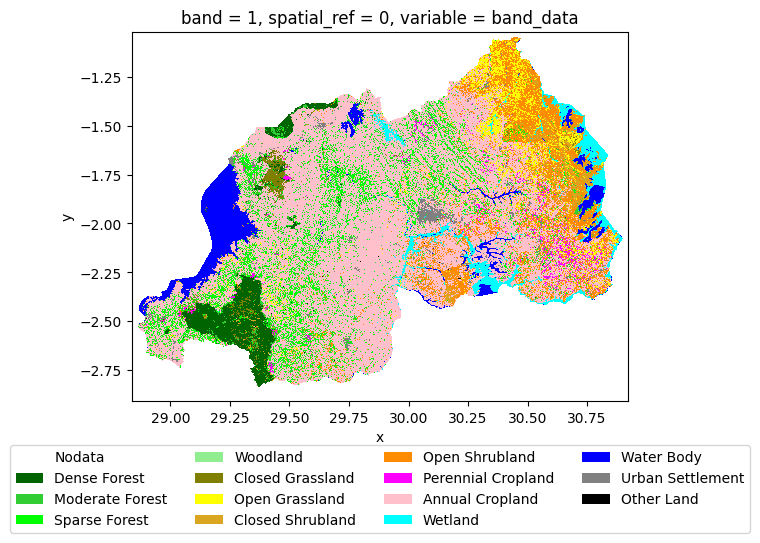

In [17]:
dict_map={'Nodata':0,'Dense Forest':1,'Moderate Forest':2,'Sparse Forest':3,'Woodland':4,
          'Closed Grassland':5,'Open Grassland':6,'Closed Shrubland':7,'Open Shrubland':8,
          'Perennial Cropland':9,'Annual Cropland':10,'Wetland':11,'Water Body':12,'Urban Settlement':13,'Other Land':14}
# display colour for each class value
colours = {0:'white',1:'darkgreen',2:'limegreen',3:'lime',4:'lightgreen',5:'olive',6:'yellow',7:'goldenrod',
           8:'darkorange',9:'magenta',10:'pink',11:'cyan',12:'blue',13:'gray',14:'black'}

fig, axes = plt.subplots(1,1)

# Plot classification map
unique_values=np.unique(classification_map)
cmap=ListedColormap([colours[k] for k in unique_values])
norm = BoundaryNorm(list(unique_values)+[np.max(unique_values)+1], cmap.N)
classification_map.plot.imshow(ax=axes, 
                   cmap=cmap,
                   norm=norm,
                   add_labels=True, 
                   add_colorbar=False,
                   interpolation='none')
# add colour legend
patches_list=[Patch(facecolor=colour) for colour in colours.values()]
axes.legend(patches_list, list(dict_map.keys()),loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))

## Select district for analysis
Now we select a district of interest for analysis. Here we select the district `Nyarugunga` and will use this district as demonstration for the rest of the workflow.  
>**Note**: If you change your district of interest, depending on its area size you may expect more time and need more memory to process. Meanwhile we recommend you select a region that has various classes as possible.

In [18]:
district_name='Mwogo'
polygon=polygons.loc[polygons[name_attribute]==district_name]

You can display the selected polygon on an interactive basemap. When you hover on each polygon you would be able to its attributes:

In [19]:
polygon.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )

With the district selected, we clip the classification map to the region for later analysis:

In [20]:
map_clipped=classification_map.rio.clip(geometries=polygon.geometry.values, crs=polygon.crs)

## Class merging

As we would like to use training samples for pure pixels as possible but the classification map contains more class than we want, we abandon classes legends that are likely mixture of pure classes, e.g. Sparse Forest and Moderate Forest and rename pure clases:  
* Dense Forest (1) as Forest (1);  
* Closed Grassland (5) as Grassland (5);  
* Closed Shrubland (7) as Shrubland (7);  
* Other Land (14) as Bare Land (14).

Here we abandon the classes Moderate Forest (2), Sparse Forest (3), Woodland (4), Open Grassland (6) and Open Shrubland (8) from the map to be used for training data generation, so set them as Nodata (0):

In [21]:
map_clipped=map_clipped.where((map_clipped!=dict_map['Moderate Forest'])
                              &(map_clipped!=dict_map['Sparse Forest'])
                              &(map_clipped!=dict_map['Woodland'])
                              &(map_clipped!=dict_map['Open Grassland'])
                              &(map_clipped!=dict_map['Open Shrubland']),0)

>**Note**: If you change your class merging strategy, some of the variables related to class names and values used in the subsequent notebooks need to be updated as well.

## Generate random training samples
We generate some randomly distributed samples for each class from the clipped classification map using the `random_sampling` function. This function takes in a few parameters:  
* `da`: a classified map in the format of 2-dimensional xarray.DataArray
* `n`: total number of points to sample.
* `min_sample_n`: Minimum number of samples to generate per class if proportional number is smaller than this. **Note that the resultant number of samples may be higher than the set `n` due to setting of this minimum number of samples.** 
* `sampling`: the sampling strategy, e.g. 'stratified_random' where each class has a number of points proportional to its relative area, 'equal_stratified_random' where each class has the same number of points, or 'manual' which allows you to define number of samples for each class.
* `out_fname`: a filepath name for the function to export a shapefile/geojson of the sampling points into a file. You can set this to `None` if you don't need to output the file.
* `class_attr`: This is the column name of output dataframe that contains the integer class values on the classified map. 
* `drop_value`: pixel value on the classification map to be excluded from sampling.  

The output of the function is a geopandas dataframe of randomly distributed points containing a column `class_attr` identifying class values. 

Here we extract around 50 training points in total and export the points in a geojson file for use in the rest of workflow. Here we use the stratified sampling method by setting 'equal_stratified_random', but also set the minimum number of samples as 3 to avoid missing samples for some minor classes. 

As mentioned earlier we don't want the abandoned classes to be included in the samples we set drop_value as 0 before implementing the function:

We now implement the function and set the output file name incorporating the district name:

In [22]:
class_attr='LC_Class_I'
out_fname='Results/Training_samples.geojson'
n=50
min_sample_n=3
gpd_random_samples=random_sampling(da=map_clipped,n=n,sampling='stratified_random',
                                   min_sample_n=min_sample_n,out_fname=out_fname,class_attr=class_attr,drop_value=0)

Class 10: sampling at 35locations
Class 11: sampling at 12locations
Class 12: sampling at 3locations
Class 13: sampling at 3locations
Class 7: sampling at 3locations
Class 14: sampling at 3locations
Class 9: sampling at 3locations


>**Note**: The output training data file can also be in other formats (e.g. shapefile) that can be read by `geopandas`, but if you change it, remember to update wherever it was used in subsequent notebooks.

Finally, we also export the clipped and class-merged map to disk for future use:

In [23]:
outname='Results/rwanda_landcover_2015_scheme_ii_clipped.tif'
write_cog(map_clipped, outname, overwrite=True)

PosixPath('Results/rwanda_landcover_2015_scheme_ii_clipped.tif')